## First order latent force models

$$
    \dot{x}_p(t) = -D_p x_p(t) + \sum_{r=1}^R S_{pr} g_r(t), \qquad p=1,\ldots P.
$$

### Basic Imports

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

np.random.seed(123)
np.set_printoptions(precision=3, suppress=True)

### Simulating from the model
We are first going to define the model and simulate an observation from it by directly solving the model with a single driving force, $g(t) = \cos (t)$.

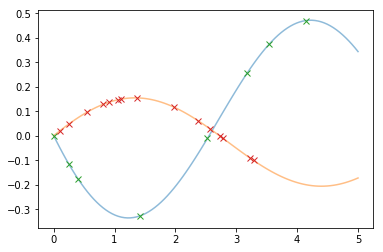

In [2]:
S = np.array([[-0.5],
                [.2]])

D = np.array([.5, .3])

g = lambda t: np.cos(t)

# Dense set of time points to solve the model on
ttd = np.linspace(0., 5., 100)

# Time-Evolution equation
def dXdt(X, t):
    # equivalent to diag(-D).dot(X) + S.dot(g)
    return -D * X + S.dot(g(t))[:, 0]

# numerically solve the ODE
sol = odeint(dXdt, [0., 0.], ttd)

# subsample the time vector to create our training data
N1 = 8  # no. of samples from x(t)
N2 = 15   # no. of samples from y(t)

xind = np.sort(
    np.random.choice(ttd.size, size=N1, replace=False))

# sample only from the 1st two thirds of y(t)
yind = np.sort(
    np.random.choice(ttd.size * 2 // 3, size=N2, replace=False))

t1, X = ttd[xind], sol[xind, 0]
t2, Y = ttd[yind], sol[yind, 1]

fig, ax = plt.subplots()
_ = ax.plot(ttd, sol, alpha=0.5)
_ = ax.plot(t1, X, 'x')
_ = ax.plot(t2, Y, 'x')

In [3]:
from lfm_flow.kernels import LFM1_RBF
from lfm_flow.latentforcemodels import LLFM
import tensorflow as tf

def reset_session():
    """Creates a new global, interactive session in Graph-mode."""
    global sess
    try:
        tf.reset_default_graph()
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession()

reset_session()

lf_length_scales = np.array([1., ])

# initial conditions for kernel -- cheat in this notebook
S0 = S.copy()
D0 = D.copy()

kern = LFM1_RBF(D0, S0, lf_length_scales)
lfm = LLFM(kern)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


TypeError: __init__() missing 1 required positional argument: 'index_points'

### Data Input

ToDo Further remarks about shaping of input data

In [ ]:
# Temporary ugly adding of training data to lfm object

# concatenate to single augmented time vector...
tt_aug = np.concatenate([t1, t2])
# ...and remember the shape of the original vectors
tt_aug_shape = [t1.size, t2.size]

lfm.t_input = tt_aug
lfm.t_input_shape = tt_aug_shape

# Store training data as shape (N_obs, N_replicates)
lfm.Y = tf.constant(np.concatenate([X, Y]),
                    dtype=np.float64)[:, None]

### Specifying optimizer

In [ ]:
# Build a tensorflow operator to return the log_likelihood
log_likelihood = lfm._build_likelihood()

# construct an optimiser
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(-log_likelihood)

# specify no. of iterations for model fitting...
# ... and a container for the values
num_iters = 500


### Training

ToDo Tidy way to reinitialize

In [ ]:
sess.run(tf.global_variables_initializer())

def train(num_iters):
    lls_ = np.zeros(num_iters, np.float64)
    for i in range(num_iters):
        _, lls_[i] = sess.run([train_op, log_likelihood])
    return lls_

lls_ = train(500)
fig, ax = plt.subplots()
lines = ax.plot(lls_, 'C0-')

In [ ]:
D, S, lf_length_scales = sess.run(
    [lfm.kernel.D, lfm.kernel.S, lfm.kernel.lf_length_scales])

print(D)
print(S)
print(lf_length_scales)

In [ ]:
mf, covf = lfm.predict_lf(ttd, return_cov=True)
mf, covf = sess.run([mf, covf])

fig2, ax = plt.subplots()
ax.plot(ttd, np.cos(ttd), 'k-.')

stdf = np.diag(covf)
stdf = np.sqrt(stdf)
ax.plot(ttd, mf, 'C0-')
ax.fill_between(ttd, mf[:, 0] + 2*stdf, mf[:, 0] - 2*stdf,
                alpha=0.5, facecolor='C0')
plt.show()
